## COEXP

This notebook tries to find the best parameters for the coexp feature.

Evaluation: Avg and Std of weighted F1 from nested cross validation of Naive Bayes, SVM? 

# Imports, globals

In [1]:
import os
import sys

sys.path.append('../src')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank1D, Rank2D

import pandas as pd
import numpy as np
import seaborn as sns

from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from features.pssm import calculate_pssm_feature
from features.coexp import calculate_coexp_feature
from models.eval import nested_crossval
from visualization.feature_plots import create_plot

In [2]:
LOG_FILE = "../logs/athaliana_amino_sugar.log"
N_THREADS = 16
IDENTITY_THRESHOLD=70

# Dataset

In [3]:
# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w"):
        pass

create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Membrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="remove",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose=True,
    tax_ids_filter=[3702],
    output_tsv="../data/datasets/athaliana_amino_sugar.tsv",
    output_fasta="../data/datasets/athaliana_amino_sugar.fasta",
    output_log=LOG_FILE,
)

In [4]:
cd_hit(
    executable_location="cd-hit",
    input_fasta=f"../data/datasets/athaliana_amino_sugar.fasta",
    output_fasta=f"../data/datasets/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    log_file=LOG_FILE,
    identity_threshold=IDENTITY_THRESHOLD,
    n_threads=N_THREADS,
    memory=4096,
    verbose=True,
)

In [5]:
fasta_to_labels(
    input_fasta=f"../data/datasets/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    output_tsv=f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
)
pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
    index_col=0,
).labels.value_counts()

Sugar transport         84
Amino-acid transport    33
Name: labels, dtype: int64

## Labels

In [6]:
fasta_to_labels(
    input_fasta=f"../data/datasets/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    output_tsv=f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
)
df_labels = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
    index_col=0,
)

# Evaluation 1: Percentages, not normalized exp data

## Feature generation

In [13]:
for neighbor_count in list(range(5,31,5)):
    for selected_neighbor_count in range(1,neighbor_count,2):
        print(neighbor_count, selected_neighbor_count)
        calculate_coexp_feature(
            gene_expression_folder="../data/intermediate/gene_expression/athaliana",
            fasta_file_training="../data/datasets/athaliana_amino_sugar_cluster{}.fasta".format(
                IDENTITY_THRESHOLD
            ),
            log_file=LOG_FILE,
            gene_pos_file="../data/intermediate/gene_positions/gene_positions_athaliana.tsv",
            go_file="../data/intermediate/gene_ontology/goa_athaliana.tsv",
            output_folder="../data/features/coexp/athaliana_amino_sugar_cluster{}".format(
                IDENTITY_THRESHOLD
            ),
            neighbor_count=neighbor_count,
            selected_neighbor_count=selected_neighbor_count,
            go_percentage_threshold=0.8,
            feature_type="percentage",
            ontologies=["F", "P", "C"],
            verbose=True,
            n_threads=N_THREADS,
        )


5 1
5 3
10 1
10 3
10 5
10 7
10 9
15 1
15 3
15 5
15 7
15 9
15 11
15 13
20 1
20 3
20 5
20 7
20 9
20 11
20 13
20 15
20 17
20 19
25 1
25 3
25 5
25 7
25 9
25 11
25 13
25 15
25 17
25 19
25 21
25 23
30 1
30 3
30 5
30 7
30 9
30 11
30 13
30 15
30 17
30 19
30 21
30 23
30 25
30 27
30 29


## Reading the files

Once with quantile normaliued expression data, once with unprocessed expression data.

In [18]:
coexp_dataframes = []
NORMALIZED = True

for neighbor_count in list(range(5,31,5)):
    for selected_neighbor_count in range(1,neighbor_count,2):
        df = pd.read_table(
            "../data/features/coexp/athaliana_amino_sugar_cluster70/e_tabm_17{}_n{}_s{}_p0.8_percentage_CFP.tsv".format(
                "_norm" if NORMALIZED else "",neighbor_count, selected_neighbor_count
            ),
            index_col=0,
        )
        df_labels_filtered = df_labels.loc[df.index]
        coexp_dataframes.append([neighbor_count, selected_neighbor_count, df, df_labels_filtered])

In [16]:
coexp_dataframes_normalized = []
NORMALIZED = False

for neighbor_count in list(range(5,31,5)):
    for selected_neighbor_count in range(1,neighbor_count,2):
        df = pd.read_table(
            "../data/features/coexp/athaliana_amino_sugar_cluster70/e_tabm_17{}_n{}_s{}_p0.8_binary_CFP.tsv".format(
                "_norm" if NORMALIZED else "",neighbor_count, selected_neighbor_count
            ),
            index_col=0,
        )
        df_labels_filtered = df_labels.loc[df.index]
        coexp_dataframes_normalized.append([neighbor_count, selected_neighbor_count, df, df_labels_filtered])

In [23]:
coexp_dataframes[1][2]

,neighbor0_Amino-acid transport_transporters,neighbor0_Amino-acid transport_neighbors,neighbor1_Amino-acid transport_transporters,neighbor1_Amino-acid transport_neighbors,neighbor2_Amino-acid transport_transporters,neighbor2_Amino-acid transport_neighbors,neighbor0_Sugar transport_transporters,neighbor0_Sugar transport_neighbors,neighbor1_Sugar transport_transporters,neighbor1_Sugar transport_neighbors,neighbor2_Sugar transport_transporters,neighbor2_Sugar transport_neighbors
Uniprot,,,,,,,,,,,,
Q9SFG0,0.000000,0.666667,0.100000,0.500000,0.000000,1.000000,0.166667,0.833333,0.300000,0.700000,0.000000,1.000000
O04249,0.076923,0.538462,0.200000,0.600000,0.500000,1.000000,0.230769,0.538462,0.200000,0.600000,0.500000,1.000000
Q56ZZ7,0.142857,0.928571,0.000000,0.800000,0.000000,0.750000,0.357143,0.857143,0.000000,1.000000,0.000000,0.750000
Q8H184,0.000000,1.000000,0.000000,1.000000,0.200000,0.400000,0.500000,1.000000,0.000000,1.000000,0.200000,0.900000
Q8L7R8,0.250000,1.000000,0.000000,0.400000,0.125000,1.000000,0.250000,1.000000,0.000000,0.400000,0.250000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
Q8RXL8,0.333333,1.000000,0.000000,0.875000,0.166667,0.166667,0.333333,1.000000,0.375000,0.875000,0.500000,1.000000
Q94B65,0.100000,1.000000,0.000000,1.000000,0.000000,1.000000,0.200000,1.000000,0.500000,1.000000,0.333333,1.000000
Q0WWW9,0.000000,0.400000,0.000000,1.000000,0.000000,1.000000,0.000000,0.200000,0.250000,0.750000,0.250000,1.000000


## Transporter mit nicht genug Daten

- 6 Zucker-transporter haben nicht genug Daten für das COEXP Feature.

In [74]:
print(df_labels.value_counts())
print(coexp_dataframes[3][3].value_counts())

df_annotations = pd.read_table("../data/datasets/athaliana_amino_sugar.tsv", index_col=0)

df_annotations.loc[df_labels[~df_labels.index.isin(coexp_dataframes[3][3].index)].index]

labels              
Sugar transport         84
Amino-acid transport    33
dtype: int64
labels              
Sugar transport         78
Amino-acid transport    33
dtype: int64


,keywords_transport,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,
Q84WN3,Sugar transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
A8MRY9,Sugar transport,UGNT1 At4g32272 F10M6.90,UDP-N-acetylglucosamine transporter UGNT1 (UDP...,NaN,3702,MRNNPVLPVSDPPLAGENDSDGKGVDDRLFKGSAMTKRGAYAALSY...
F4JN00,Sugar transport,At4g35335 At4g35330/At4g35340 F23E12.100/F23E1...,CMP-sialic acid transporter 4 (CMP-SA-Tr 4) (C...,NaN,3702,MEYRKIKDEDDHDVASDIESVKGKSHTVASSNIAMATLGVGSSERI...
Q8GY97,Sugar transport,At2g43240 F14B2.18,CMP-sialic acid transporter 2 (CMP-SA-Tr 2) (C...,NaN,3702,MKNGMAECSVCRSRLVSPSSKAISRAYDNYNYKIRVSSKQRALNVF...
Q84L09,Sugar transport,GONST2 At1g07290 F22G5.37,GDP-mannose transporter GONST2 (Protein GOLGI ...,2.A.7.13.4,3702,MSAVKLEAIVCHEPDESELSHLSDNGSKTKNGVVFQLLDQKSSEHR...
F4IHS9,Sugar transport,UXT1 At2g28315 T1B3.18,UDP-xylose transporter 1,NaN,3702,MGEMKSMQMGVIGALFLSVASSVSIVICNKALMTNLGFPFATTLTS...


## Evaluation

First a simple model. The results show that I should go back and make more parameters available for optimization, and look at the preprocessing for the expression data once again. 

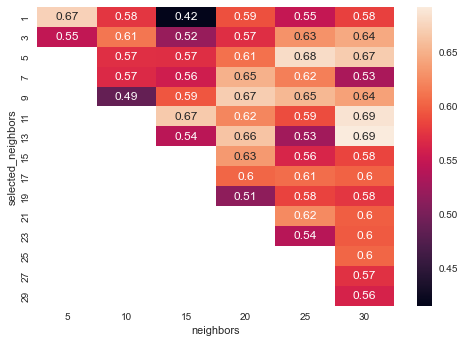

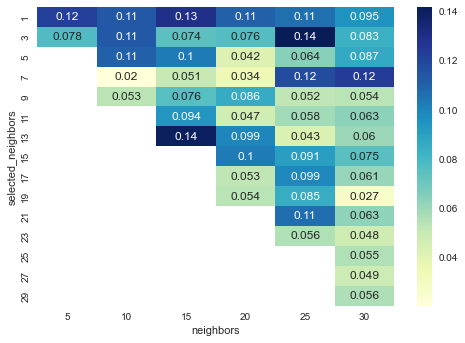

In [64]:
results_long = []

# neighbor_count, selected_neighbor_count, df_features, df_labels_filtered = coexp_dataframes[7]
model = make_pipeline(StandardScaler(), SVC(class_weight="balanced"))

for neighbor_count, selected_neighbor_count, df_features, df_labels_filtered in coexp_dataframes:
    cv_results = cross_val_score(
        estimator=model,
        scoring="f1_weighted",
        n_jobs=16,
        cv=5,
        X=df_features.to_numpy(),
        y=np.where(df_labels_filtered.labels.to_numpy() == "Sugar transport", 1, 0),
    )
    results_long.append([neighbor_count, selected_neighbor_count, cv_results.mean(), cv_results.std()])


results_long = pd.DataFrame.from_records(results_long, columns=["neighbors", "selected_neighbors", "mean", "std"])

results_df = results_long.pivot(columns="neighbors", index="selected_neighbors")

sns.heatmap(results_df["mean"], annot=True)
plt.title("mean")
plt.show()
sns.heatmap(results_df["std"], annot=True,cmap="YlGnBu")
plt.title("std")
plt.show()